In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Our first task was to build a model that would accurately predict whether a photo selected at random from the dataset was of Tom Mitchell:

Finished Training
Training time: 121.00815343856812
Accuracy of the network on the test images: 100.0%


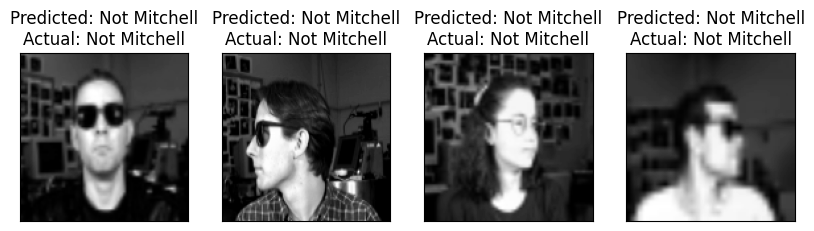

In [ ]:
import cv2
from torchvision.datasets import ImageFolder
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import time
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np

# Various transforms to be applied to the images
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

# dataset Class for "mitchell" vs not "mitchell"
class MitchellOrNotDataset(Dataset):
    def __init__(self, root_dir, transform=transform):
        # Load the dataset using ImageFolder
        self.data = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        # Return the number of items in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get an image and its label
        image, label = self.data[idx]
        # Assign a binary label: 1 for 'mitchell', 0 for others
        label = 1 if self.data.classes[label] == 'mitchell' else 0
        return image, label

# Neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d((3, 2), (2, 2))
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 28 * 29, 120)  # Adjust the input features to match the output from conv2
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Output layer for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 28 * 29)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(net, trainloader, optimizer, criterion, epochs = 3):
    net.train()
    start = time.time()
    for epoch in range(epochs):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    end = time.time()
    print(f'Finished Training')
    print(f'Training time: {end - start}')
    checkpoint = {
        'epoch': epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, 'model_checkpoint_T1.pth')



#Function for visualizing predictions
def visualize_predictions(net, loader, num_images=4):
    net.eval()
    images, labels = next(iter(loader))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    images = images.numpy()

    fig = plt.figure(figsize=(10, 10))

    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx+1, xticks=[], yticks=[])
        img = images[idx].squeeze()  # Removing channel dimension for grayscale
        img = img * 0.5 + 0.5  # unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')

        # Convert tensors to integers
        predicted_label = predicted[idx].item()
        actual_label = labels[idx].item()

        # defining class names
        class_names = {0: 'Not Mitchell', 1: 'Mitchell'}
        ax.set_title(f"Predicted: {class_names[predicted_label]}\nActual: {class_names[actual_label]}")

# Test function
def test(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    visualize_predictions(net, testloader)

# Main function
def main():
    # Use the custom dataset class for loading data
    dataset = MitchellOrNotDataset(root_dir='/content/drive/My Drive/faces/faces', transform=transform)

    # Splitting the dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # DataLoaders
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Network, optimizer, and criterion
    net = Net()  # Assuming Net is your neural network class
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Train and test the network
    train(net, trainloader, optimizer, criterion)
    test(net, testloader)

if __name__ == '__main__':
    main()


So far, so good. The next task is slightly more complex; predicting what kind of facial expression is being made by the person in a photo selected at random from the dataset.

Finished Training. Training time: 12252.215584516525
Accuracy of the network on the test images: 92.26666666666667%


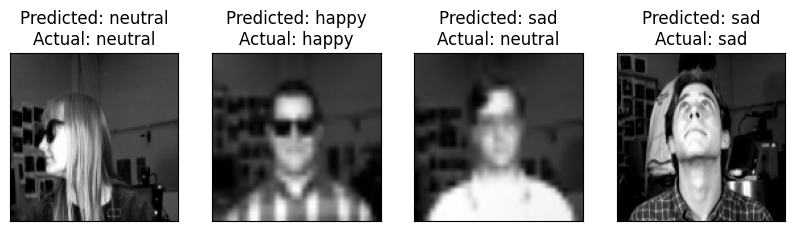

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import time
import os
import matplotlib.pyplot as plt
import numpy as np

# dataset Class for facial expressions
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = datasets.ImageFolder(root=root_dir, transform=transform)
        self.expression_to_idx = {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, _ = self.data[idx]
        filename = os.path.basename(self.data.imgs[idx][0])
        expression = None
        for exp in self.expression_to_idx:
            if exp in filename:
                expression = self.expression_to_idx[exp]
                break
        label = expression if expression is not None else -1
        return image, label

# Transform to be applied to the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d((3, 2), (2, 2))
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 28 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)  # Output layer for 4 facial expressions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 28 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(net, trainloader, optimizer, criterion, epochs = 300):
    net.train()
    start = time.time()
    for epoch in range(epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    end = time.time()
    print(f'Finished Training. Training time: {end - start}')
    checkpoint = {
        'epoch': epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, 'model_checkpoint_T2.pth')

# Function for visualising results
def visualize_predictions(net, loader, class_names, num_images=4):
    net.eval()
    images, labels = next(iter(loader))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    images = images.numpy()

    fig = plt.figure(figsize=(10, 10))

    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx+1, xticks=[], yticks=[])
        img = images[idx].transpose((1, 2, 0))  # Convert to HxWxC format
        img = img * 0.5 + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img.squeeze(), cmap='gray')

        predicted_label = int(predicted[idx].cpu().numpy())
        actual_label = int(labels[idx].cpu().numpy())

        ax.set_title(f"Predicted: {class_names.get(predicted_label, 'Unknown')}\nActual: {class_names.get(actual_label, 'Unknown')}")

# Test function
def test(net, testloader, class_names):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    visualize_predictions(net, testloader, class_names)

# Main function
def main():
    # Data loading
    dataset = FacialExpressionDataset(root_dir='/content/drive/My Drive/faces/faces', transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Initialize the network, loss function, and optimizer
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    # Class names
    class_names = {0: 'angry', 1: 'happy', 2: 'neutral', 3: 'sad'}

    # Train and test the network
    train(net, trainloader, optimizer, criterion)
    test(net, testloader, class_names)

if __name__ == '__main__':
    main()
